In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [7]:
class ClassificationAnalyser:
    def __init__(self,path,res_col=None,missing_data=[],categorical_data=[],label_encoding=[]):
        self.dataset = pd.read_csv(path)
        self.result = dict()
        if res_col is None:
            res_col = len(self.dataset.columns)-1
        self.X = self.dataset.iloc[:, [i for i in range(len(self.dataset.columns)) if i != res_col]].values
        self.y = self.dataset.iloc[:, res_col].values
        
        #updated categorical_data and label_encoding
        categorical_data = [i - 1 if i > res_col else i for i in categorical_data]
        label_encoding = [i - 1 if i > res_col else i for i in label_encoding]

        #missing data
        if missing_data:
            from sklearn.impute import SimpleImputer
            imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
            imputer.fit(self.X[:, missing_data])
            self.X[:, missing_data] = imputer.transform(self.X[:, missing_data])
            
        #label encoding
        from sklearn.preprocessing import LabelEncoder
        le = LabelEncoder()
        for i in label_encoding:
            self.X[:, [i]] = le.fit_transform(self.X[:, [i]])
            
        #catagorical data
        if categorical_data:
            from sklearn.compose import ColumnTransformer
            from sklearn.preprocessing import OneHotEncoder
            ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), categorical_data)], remainder='passthrough')
            self.X = np.array(ct.fit_transform(self.X))
            
        #feature scaling
        from sklearn.preprocessing import StandardScaler
        self.sc_x = StandardScaler()
        self.X_sc = self.sc_x.fit_transform(self.X)
        
    def k_fold_cross_validation(self, model, cv=10, xtrain=None):
        if xtrain is None:
            xtrain = self.X_sc
        from sklearn.model_selection import cross_val_score
        accuracies = cross_val_score(estimator=model, X=xtrain,y=self.y, cv=cv)
        return accuracies.mean(), accuracies.std()
    
    def grid_search(self, model, parameters, cv=10, xtrain=None, scoring='accuracy'):
        if xtrain is None:
            xtrain = self.X_sc
        from sklearn.model_selection import GridSearchCV
        grid_search = GridSearchCV(estimator=model, param_grid=parameters, scoring=scoring, cv=cv, n_jobs=-1)
        grid_search.fit(xtrain, self.y)
        return grid_search.best_params_ , grid_search.best_score_ 
    
    def logistic_regression(self):
        from sklearn.linear_model import LogisticRegression
        
        # Create a Linear Regression model instance
        model = LogisticRegression()
        
        # Define parameters for grid search
        logistic_regression_parameters = [{'C': [0.1, 0.5, 1, 5, 10]}]
        
        # Perform grid search to find the best parameters
        best_params, best_accuracy = self.grid_search(model, logistic_regression_parameters)
        
        # Reassign the model instance with the best parameters found
        model = LogisticRegression(**best_params)
        
        # Perform k-fold cross validation
        accuracy, std_dev = self.k_fold_cross_validation(model)
        
        # Store the results
        self.result['Logistic Regression'] = (accuracy, std_dev, best_params)
        
        # Print the results
        print('Logistic Regression')
        print('Accuracy: {:.2f} %'.format(accuracy*100))
        print('Standard Deviation: {:.2f} %'.format(std_dev*100))
        print('Best Parameters:', best_params)
        
        # return the parameters
        return best_params
    
    def k_nearest_neighbours(self):
        from sklearn.neighbors import KNeighborsClassifier
        
        # Create a K-NN model instance
        model = KNeighborsClassifier()
        
        # Define parameters for grid search
        k_nearest_neighbours_parameters = [{'n_neighbors': [5, 7, 9, 11, 13]}]
        
        # Perform grid search to find the best parameters
        best_params, best_accuracy = self.grid_search(model, k_nearest_neighbours_parameters)
        
        # Reassign the model instance with the best parameters found
        model = KNeighborsClassifier(**best_params)
        
        # Perform k-fold cross validation
        accuracy, std_dev = self.k_fold_cross_validation(model)
        
        # Store the results
        self.result['K-Nearest Neighbours'] = (accuracy, std_dev, best_params)
        
        # Print the results
        print('K-Nearest Neighbours')
        print('Accuracy: {:.2f} %'.format(accuracy*100))
        print('Standard Deviation: {:.2f} %'.format(std_dev*100))
        print('Best Parameters:', best_params)
        
        # return the parameters
        return best_params
    
    def support_vector_machine(self):
        from sklearn.svm import SVC
        
        # Create a SVM model instance
        model = SVC()
        
        # Define parameters for grid search
        support_vector_machine_parameters = [{'C': [0.1, 0.5, 1, 5, 10], 'kernel': ['linear']},
                                            {'C': [0.1, 0.5, 1, 5, 10], 'kernel': ['rbf'], 'gamma': [0.1, 0.5, 1, 5, 10]}]
        
        # Perform grid search to find the best parameters
        best_params, best_accuracy = self.grid_search(model, support_vector_machine_parameters)
        
        # Reassign the model instance with the best parameters found
        model = SVC(**best_params)
        
        # Perform k-fold cross validation
        accuracy, std_dev = self.k_fold_cross_validation(model)
        
        # Store the results
        self.result['Support Vector Machine'] = (accuracy, std_dev, best_params)
        
        # Print the results
        print('Support Vector Machine')
        print('Accuracy: {:.2f} %'.format(accuracy*100))
        print('Standard Deviation: {:.2f} %'.format(std_dev*100))
        print('Best Parameters:', best_params)
        
        # return the parameters
        return best_params
        
    def naive(self):
        from sklearn.naive_bayes import GaussianNB
        
        # Create a Naive Bayes model instance
        model = GaussianNB()
        
        # Perform k-fold cross validation
        accuracy, std_dev = self.k_fold_cross_validation(model)
        
        # Store the results
        self.result['Naive Bayes'] = (accuracy, std_dev, {})
        
        # Print the results
        print('Naive Bayes')
        print('Accuracy: {:.2f} %'.format(accuracy*100))
        print('Standard Deviation: {:.2f} %'.format(std_dev*100))
        
        # return the parameters
        return {}
        
    def decision_tree(self):
        from sklearn.tree import DecisionTreeClassifier
        
        # Create a Decision Tree model instance
        model = DecisionTreeClassifier()
        
        # Define parameters for grid search
        decision_tree_parameters = [{'criterion': ['gini', 'entropy'], 'splitter': ['best', 'random']}]
        
        # Perform grid search to find the best parameters
        best_params, best_accuracy = self.grid_search(model, decision_tree_parameters)
        
        # Reassign the model instance with the best parameters found
        model = DecisionTreeClassifier(**best_params)
        
        # Perform k-fold cross validation
        accuracy, std_dev = self.k_fold_cross_validation(model)
        
        # Store the results
        self.result['Decision Tree'] = (accuracy, std_dev, best_params)
        
        # Print the results
        print('Decision Tree')
        print('Accuracy: {:.2f} %'.format(accuracy*100))
        print('Standard Deviation: {:.2f} %'.format(std_dev*100))
        print('Best Parameters:', best_params)
        
        # return the parameters
        return best_params
    
    def random_forest(self):
        from sklearn.ensemble import RandomForestClassifier
        
        # Create a Random Forest model instance
        model = RandomForestClassifier()
        
        # Define parameters for grid search
        random_forest_parameters = [{'n_estimators': [100, 200, 300], 'criterion': ['gini', 'entropy']}]
        
        # Perform grid search to find the best parameters
        best_params, best_accuracy = self.grid_search(model, random_forest_parameters)
        
        # Reassign the model instance with the best parameters found
        model = RandomForestClassifier(**best_params)
        
        # Perform k-fold cross validation
        accuracy, std_dev = self.k_fold_cross_validation(model)
        
        # Store the results
        self.result['Random Forest'] = (accuracy, std_dev, best_params)
        
        # Print the results
        print('Random Forest')
        print('Accuracy: {:.2f} %'.format(accuracy*100))
        print('Standard Deviation: {:.2f} %'.format(std_dev*100))
        print('Best Parameters:', best_params)
        
        # return the parameters
        return best_params
    
    def XGBoost(self):
        from xgboost import XGBClassifier
        
        # Create a XGBoost model instance
        model = XGBClassifier()
        
        # Define parameters for grid search
        XGBoost_parameters = [{'n_estimators': [100, 200, 300], 'learning_rate': [0.05, 0.1, 0.2], 'max_depth': [3, 4, 5]}]
        
        # Perform grid search to find the best parameters
        best_params, best_accuracy = self.grid_search(model, XGBoost_parameters)
        
        # Reassign the model instance with the best parameters found
        model = XGBClassifier(**best_params)
        
        # Perform k-fold cross validation
        accuracy, std_dev = self.k_fold_cross_validation(model)
        
        # Store the results
        self.result['XGBoost'] = (accuracy, std_dev, best_params)
        
        # Print the results
        print('XGBoost')
        print('Accuracy: {:.2f} %'.format(accuracy*100))
        print('Standard Deviation: {:.2f} %'.format(std_dev*100))
        print('Best Parameters:', best_params)
        
        # return the parameters
        return best_params
    
    def CatBoost(self):
        from catboost import CatBoostClassifier
        
        # Create a CatBoost model instance
        model = CatBoostClassifier()
        
        # Define parameters for grid search
        CatBoost_parameters = [{'iterations': [100, 200, 300], 'learning_rate': [0.05, 0.1, 0.2], 'depth': [3, 4, 5]}]
        
        # Perform grid search to find the best parameters
        best_params, best_accuracy = self.grid_search(model, CatBoost_parameters)
        
        # Reassign the model instance with the best parameters found
        model = CatBoostClassifier(**best_params)
        
        # Perform k-fold cross validation
        accuracy, std_dev = self.k_fold_cross_validation(model)
        
        # Store the results
        self.result['CatBoost'] = (accuracy, std_dev, best_params)
        
        # Print the results
        print('CatBoost')
        print('Accuracy: {:.2f} %'.format(accuracy*100))
        print('Standard Deviation: {:.2f} %'.format(std_dev*100))
        print('Best Parameters:', best_params)
        
        # return the parameters
        return best_params
    
    def analyze(self):
        self.logistic_regression()
        self.k_nearest_neighbours()
        self.support_vector_machine()
        self.naive()
        self.decision_tree()
        self.random_forest()
        self.XGBoost()
        self.CatBoost()
        from pprint import pprint
        pprint(self.result)
        
    def plot(self):
        for key,value in self.result.items():
            plt.scatter(value[0],value[1],label=key)
        plt.title('Model Accuracy vs Standard Deviation')
        plt.xlabel('Accuracy')
        plt.ylabel('Standard Deviation')
        plt.legend()
        plt.show()
    

In [8]:
analyser = ClassificationAnalyser('datasets/Social_Network_Ads.csv')

In [9]:
analyser.analyze()

Logistic Regression
Accuracy: 82.25 %
Standard Deviation: 11.48 %
Best Parameters: {'C': 0.1}
K-Nearest Neighbours
Accuracy: 91.00 %
Standard Deviation: 7.43 %
Best Parameters: {'n_neighbors': 11}
Support Vector Machine
Accuracy: 91.00 %
Standard Deviation: 7.84 %
Best Parameters: {'C': 1, 'gamma': 1, 'kernel': 'rbf'}
Naive Bayes
Accuracy: 87.75 %
Standard Deviation: 7.86 %
Decision Tree
Accuracy: 83.50 %
Standard Deviation: 4.06 %
Best Parameters: {'criterion': 'entropy', 'splitter': 'random'}
Random Forest
Accuracy: 88.00 %
Standard Deviation: 8.79 %
Best Parameters: {'criterion': 'entropy', 'n_estimators': 300}
XGBoost
Accuracy: 90.00 %
Standard Deviation: 8.94 %
Best Parameters: {'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 200}


e:\GIT\Regression_Classification_Selector\.venv\Lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
4 fits failed out of a total of 270.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "e:\GIT\Regression_Classification_Selector\.venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "e:\GIT\Regression_Classification_Selector\.venv\Lib\site-packages\catboost\core.py", line 5201, in fit
    self._fit(X, y, cat_features, text_features, embedding_features, None, sample_weight, None, None, None, None, baseline, use_best_model,
  File "e:\GIT

0:	learn: 0.6403271	total: 131ms	remaining: 26.1s
1:	learn: 0.5953530	total: 134ms	remaining: 13.2s
2:	learn: 0.5470259	total: 136ms	remaining: 8.93s
3:	learn: 0.5079243	total: 138ms	remaining: 6.79s
4:	learn: 0.4699977	total: 141ms	remaining: 5.49s
5:	learn: 0.4474878	total: 143ms	remaining: 4.63s
6:	learn: 0.4202433	total: 146ms	remaining: 4.02s
7:	learn: 0.4050435	total: 149ms	remaining: 3.58s
8:	learn: 0.3870390	total: 154ms	remaining: 3.26s
9:	learn: 0.3694018	total: 156ms	remaining: 2.96s
10:	learn: 0.3575974	total: 176ms	remaining: 3.02s
11:	learn: 0.3435581	total: 187ms	remaining: 2.92s
12:	learn: 0.3299861	total: 189ms	remaining: 2.72s
13:	learn: 0.3186255	total: 192ms	remaining: 2.55s
14:	learn: 0.3097272	total: 195ms	remaining: 2.4s
15:	learn: 0.3009570	total: 197ms	remaining: 2.27s
16:	learn: 0.2936594	total: 200ms	remaining: 2.15s
17:	learn: 0.2862398	total: 202ms	remaining: 2.04s
18:	learn: 0.2782823	total: 205ms	remaining: 1.95s
19:	learn: 0.2713257	total: 208ms	remainin

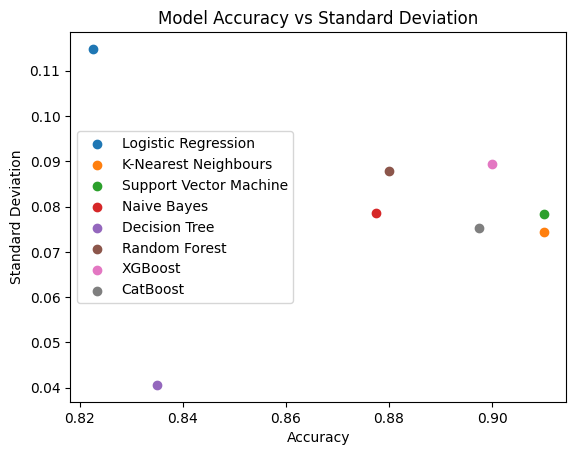

In [10]:
analyser.plot()